# A Deep Learning Approach to Fault Detection and Classification in Datacenters.
In this project we'll build a deep convolutional neural network to detect and classify 5 different states of server operation.

We setup Weights & Biases to log models metrics, inspect performance and share findings about the best architecture for the network. 

Here is the link used for the dataset used in this project https://www.kaggle.com/liuhangaz/thermal-images-of-the-server

### Running This Notebook
1. Click "Open in playground" to create a copy of this notebook for yourself.
2. Save a copy in Google Drive for yourself.
3. To enable a GPU, please click Edit > Notebook Settings. Change the "hardware accelerator" to GPU.
4. Step through each section below, pressing play on the code blocks to run the cells.

Feel free to fork this notebook, tweak the parameters, or try the model with your own dataset if that is what you want.

# Setup
Start out by installing the experiment tracking library and setting up your free W&B account:


*   **pip install wandb** – Install the W&B library
*   **import wandb** – Import the wandb library
*   **from wandb.keras import WandbCallback** – Import the wandb [keras callback](https://docs.wandb.com/library/frameworks/keras)


In [1]:
# WandB – Install the W&B library
!pip install wandb -q
!pip install opencv-python
import wandb
from wandb.keras import WandbCallback

     |████████████████████████████████| 1.4MB 3.4MB/s 
     |████████████████████████████████| 102kB 7.9MB/s 
     |████████████████████████████████| 112kB 23.4MB/s 
     |████████████████████████████████| 102kB 8.2MB/s 
     |████████████████████████████████| 163kB 21.2MB/s 
     |████████████████████████████████| 71kB 6.1MB/s 
     |████████████████████████████████| 71kB 7.2MB/s 


wandb: WARNING import wandb.keras called before import keras or import tensorflow.keras.  This can lead to a version mismatch, W&B now assumes tensorflow.keras


In [2]:
# Load the contents of drive to notebook
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
# Essentials
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn import model_selection
from sklearn.model_selection import train_test_split, learning_curve, KFold, cross_val_score, StratifiedKFold

# Models
import tensorflow as tf

# Image Libraries
from PIL import Image, ImageFilter, ImageStat
import imageio, glob, cv2
import os
import itertools
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid
import random
random.seed(42)
%matplotlib inline

# Ignore excessive warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Explore The Thermal Image Dataset

In [4]:
# Fetch the dataset from drive
data_root = ("/content/drive/My Drive/cropped_dataset")


## Display Random Dataset Images

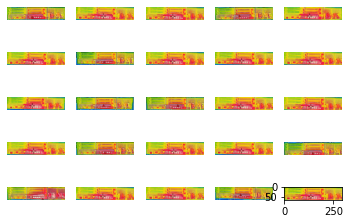

In [5]:
#print(folder_name)
sum_ = 0
# Visualize images in the dataset
server_states = glob.glob("/content/drive/My Drive/cropped_dataset/1SX/*.jpg")
i = 0
for state in server_states[0:25]:
            #print(filename)
    image = Image.open(state)
    plt.axis('off')
    plt.subplot(5, 5, i+1) #.set_title(l)
    plt.imshow(image)
    i += 1



### Feature Engineering

In [9]:
# Define the labels for the Simpsons characters we're detecting
character_names = {0 : '1SX', 1 : '2OH', 2 : '3MF', 3 : '4CF', 4 : '5EB'}

img_size = 64
num_classes = 5
dir = "/content/drive/My Drive/cropped_dataset"

print("Calculating...")
# Load training data"/content/drive/My Drive/cropped_dataset"
X_train = []
y_train = []
for label, name in character_names.items():
   list_images = os.listdir(dir+'/'+name)
   #print("First for loop loading...")
   for image_name in list_images:
       image = imageio.imread(dir+'/'+name+'/'+image_name)
       X_train.append(cv2.resize(image, (img_size,img_size)))
       y_train.append(label)
       print("Second for loop loading...")

X_train = np.array(X_train)
y_train = np.array(y_train)

print(len(X_train))

# Split data for cross validation  
X_train = X_train[:1180] 
y_train = y_train[:1180]

X_test = X_train[-170:] 
y_test = y_train[-170:]

# Normalize the data
X_train = X_train / 255.0
X_test = X_test / 255.0

# One hot encode the labels (neural nets only like numbers)
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

Calculating...
Second for loop loading...
Second for loop loading...
Second for loop loading...
Second for loop loading...
Second for loop loading...
Second for loop loading...
Second for loop loading...
Second for loop loading...
Second for loop loading...
Second for loop loading...
Second for loop loading...
Second for loop loading...
Second for loop loading...
Second for loop loading...
Second for loop loading...
Second for loop loading...
Second for loop loading...
Second for loop loading...
Second for loop loading...
Second for loop loading...
Second for loop loading...
Second for loop loading...
Second for loop loading...
Second for loop loading...
Second for loop loading...
Second for loop loading...
Second for loop loading...
Second for loop loading...
Second for loop loading...
Second for loop loading...
Second for loop loading...
Second for loop loading...
Second for loop loading...
Second for loop loading...
Second for loop loading...
Second for loop loading...
Second for lo

# Training A Simple Neural Network

### Define Your Hyperparameters
*   **wandb.init()** – Initialize a new W&B run. Each run is single execution of the training script.
*   **wandb.config** – Save all your hyperparameters in a config object. This lets you use W&B app to sort and compare your runs by hyperparameter values.

In [10]:
# Initilize a new wandb run
wandb.init(entity="wandb", project="keras-intro")

# Default values for hyper-pa4/2QGIBqzPcD7jN-wc27fpRrrmPWhoRFNSZcmUJVdSGbvPI342JQXZGA8rameters
config = wandb.config # Config is a variable that holds and saves hyperparameters and inputs
config.learning_rate = 0.01
config.epochs = 100
config.img_width= 64
config.img_height= 64
config.num_classes = 5
config.batch_size = 32
config.validation_size = 50
config.weight_decay = 0.0005
config.activation = 'relu'
config.optimizer = 'nadam'
config.seed = 42

### Define the Two Deep CNN models with Data Augmentation

By deactivation 64 filter convolutional layer we trained the first model and then reactivated it to train the second model.

Below, we define our model in Keras, and add the following lines of code to log models metrics, visualize performance and output and track our experiments easily:
*   **callbacks=[WandbCallback()]** – Fetch all layer dimensions, model parameters and log them automatically to your W&B dashboard.

In [11]:
%%wandb
# Determine input shape
input_shape = (X_train.shape[1], X_train.shape[2], 3)

# Define the model architecture - This is a simplified version of the VGG19 architecture
model = tf.keras.models.Sequential()

# Set of Conv2D, Conv2D, MaxPooling2D layers with 32 and 64 filters
# Conv2D adds a convolution layer that generates 2 dimensional feature maps to learn different aspects of our image
model.add(tf.keras.layers.Conv2D(filters = 32, kernel_size = (3, 3), padding = 'same', 
                  activation ='relu', input_shape = input_shape))

# MaxPooling2D layer reduces the size of the image representation our convolutional layers learnt,
# and in doing so it reduces the number of parameters and computations the network needs to perform.
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

# Conv2D adds a conv  olution layer that generates 2 dimensional feature maps to learn different aspects of our image
#model.add(tf.keras.layers.Conv2D(filters = 64, kernel_size = (3, 3), padding = 'same', 
                 # activation ='relu', input_shape = input_shape))

# MaxPooling2D layer reduces the size of the image representation our convolutional layers learnt,
# and in doing so it reduces the number of parameters and computations the network needs to perform.
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

# Flattens our array so we can feed the convolution layer outputs (a matrix) into our fully connected layer (an array)
model.add(tf.keras.layers.Flatten())

# Dense layer creates dense, fully connected layers with x inputs and y outputs - it simply outputs the dot product of our inputs and weights
model.add(tf.keras.layers.Dense(512, activation ='relu'))

model.add(tf.keras.layers.Dense(num_classes, activation = "softmax"))

# Define the optimizer
optimizer = tf.keras.optimizers.Nadam(lr=config.learning_rate, beta_1=0.9, beta_2=0.999, clipnorm=1.0)

model.compile(loss = "categorical_crossentropy", optimizer = optimizer, metrics=['accuracy'])

# Data augmentation
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=15,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images
    vertical_flip=False)  # randomly flip images
# (std, mean, and principal components if ZCA whitening is applied).
datagen.fit(X_train)

# Fit the model to the training data


model.fit_generator(datagen.flow(X_train, y_train, batch_size=config.batch_size),
                    steps_per_epoch=len(X_train) / 32, epochs=config.epochs,
                    validation_data=(X_test, y_test), verbose=0,
                    callbacks=[WandbCallback(data_type="image", validation_data=(X_test, y_test), labels=character_names),
                                tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)])





In [ ]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 16384)             0         
_________________________________________________________________
dense_10 (Dense)             (None, 512)               8389120   
_________________________________________________________________
dense_11 (Dense)             (None, 5)                

### **Training with Transfer Learning**

In [ ]:

!pip install -q -U tf-hub-nightly
!pip install -q tfds-nightly
!pip install tensorflow_hub
import tensorflow_hub as hub


     |████████████████████████████████| 112kB 3.5MB/s 
     |████████████████████████████████| 3.4MB 3.5MB/s 


In [ ]:
%%wandb

#IMAGE_SHAPE = (65, 295)
IMAGE_SHAPE = (224, 224)

#training data directory
TRAINING_DATA_DIR = str(data_root)

datagen_kwargs = dict(rescale=1./255, validation_split=.20)
valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)
valid_generator = valid_datagen.flow_from_directory(
    TRAINING_DATA_DIR, 
    subset="validation", 
    shuffle=True,
    target_size=IMAGE_SHAPE
)

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)
train_generator = train_datagen.flow_from_directory(
    TRAINING_DATA_DIR, 
    subset="training", 
    shuffle=True,
    target_size=IMAGE_SHAPE)


for image_batch, label_batch in train_generator:
  break
image_batch.shape, label_batch.shape


print (train_generator.class_indices)

labels = '\n'.join(sorted(train_generator.class_indices.keys()))

with open('labels.txt', 'w') as f:
  f.write(labels)


!cat labels.txt

#define input image size
IMAGE_SIZE = 224

# Define the model architecture - This is a simplified version of the VGG19 architecture
model = tf.keras.Sequential([
  hub.KerasLayer("https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4", 
                 output_shape=[1280],
                 trainable=False),
  tf.keras.layers.Dropout(0.4),
  tf.keras.layers.Dense(train_generator.num_classes, activation='softmax')
])
model.build([None, 224, 224, 3])

model.build([None, 224, 224, 3])

model.summary()


print (train_generator.class_indices)

labels = '\n'.join(sorted(train_generator.class_indices.keys()))

with open('labels.txt', 'w') as f:
  f.write(labels)

# Define the optimizer
optimizer = tf.keras.optimizers.Adam(lr=1e-3)

model.compile(
  optimizer=optimizer,
  loss='categorical_crossentropy',
  metrics=['acc'])



steps_per_epoch = np.ceil(train_generator.samples/train_generator.batch_size)
val_steps_per_epoch = np.ceil(valid_generator.samples/valid_generator.batch_size)

#print(steps_per_epoch)
#print(val_steps_per_epoch)

# Fit the model to the training data

model.fit_generator(
    train_generator, 
    epochs=100,
    verbose=1,
    steps_per_epoch=steps_per_epoch,
    validation_data=valid_generator,
    validation_steps=val_steps_per_epoch,
    callbacks=[WandbCallback()])



Found 270 images belonging to 5 classes.
Found 1080 images belonging to 5 classes.
{'1SX': 0, '2OH': 1, '3MF': 2, '4CF': 3, '5EB': 4}
1SX
2OH
3MF
4CF
5EBModel: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_7 (KerasLayer)   multiple                  2257984   
_________________________________________________________________
dropout_7 (Dropout)          multiple                  0         
_________________________________________________________________
dense_11 (Dense)             multiple                  6405      
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________
{'1SX': 0, '2OH': 1, '3MF': 2, '4CF': 3, '5EB': 4}
34.0
9.0
Epoch 1/100
34/34 [==============================] - 47s 1s/step - loss: 1.7250 - acc: 0.2713 - val_loss: 1.2815 - val_acc: 0.4778
Epoch 2/100
34/34 [=======

34/34 [==============================] - ETA: 0s - loss: 0.3723 - acc: 0.8731

34/34 [==============================] - 46s 1s/step - loss: 0.3723 - acc: 0.8731 - val_loss: 0.3728 - val_acc: 0.8889
Epoch 34/100
 6/34 [====>.........................] - ETA: 25s - loss: 0.3648 - acc: 0.8646

24/34 [====================>.........] - ETA: 10s - loss: 0.3618 - acc: 0.8763

34/34 [==============================] - 46s 1s/step - loss: 0.3635 - acc: 0.8750 - val_loss: 0.3930 - val_acc: 0.8852
Epoch 35/100
34/34 [==============================] - 45s 1s/step - loss: 0.3831 - acc: 0.8630 - val_loss: 0.3794 - val_acc: 0.8889
Epoch 36/100
34/34 [==============================] - 46s 1s/step - loss: 0.3502 - acc: 0.8741 - val_loss: 0.3837 - val_acc: 0.8926
Epoch 37/100
34/34 [==============================] - 46s 1s/step - loss: 0.3672 - acc: 0.8731 - val_loss: 0.3688 - val_acc: 0.8852
Epoch 38/100
34/34 [==============================] - 45s 1s/step - loss: 0.3754 - acc: 0.8556 - val_loss: 0.3979 - val_acc: 0.8741
Epoch 39/100
34/34 [==============================] - 46s 1s/step - loss: 0.3391 - acc: 0.8796 - val_loss: 0.3711 - val_acc: 0.8889
Epoch 40/100
34/34 [==============================] - 46s 1s/step - loss: 0.3431 - acc: 0.8833 - val_loss: 0.3609 - val_acc: 0.8889
Epoch 41/100
34/34 [==============================] - 46s 1s/step - loss: 0.3589 - acc: 0

'\nmodel.fit_generator(datagen.flow(X_train, y_train, batch_size=config.batch_size),\n                    steps_per_epoch=len(X_train) / 32, epochs=config.epochs,\n                    validation_data=(X_test, y_test), verbose=0,\n                    callbacks=[WandbCallback(data_type="image", validation_data=(X_test, y_test), labels=character_names),\n                                tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)])\n\n'